In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

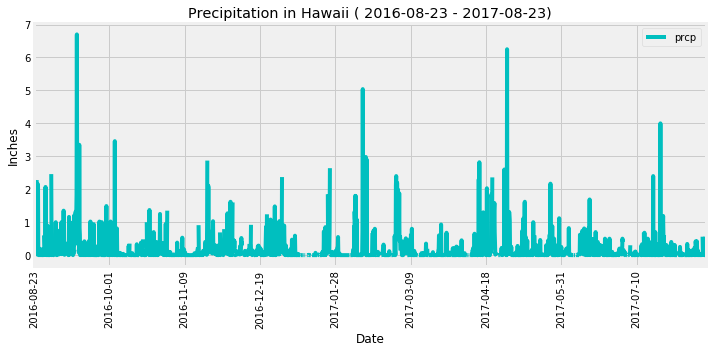

In [12]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results


# get latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#using ravel to extract string from the above query object
latest_date = list(np.ravel(latest_date))[0]

#converting the string returned above to datetime format
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

#calculating the date 1 years ago using timedelta
date_year_ago = (latest_date - dt.timedelta(days=365)).date()

# Perform a query to retrieve the data and precipitation scores
precip_result = session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date >= date_year_ago ).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(prcp_result)
precip_df.set_index("date",inplace=True)

# Sort the dataframe by date
precip_df.sort_index(ascending = True,inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize = (10,5),rot = 90,color = 'c')
plt.title(f"Precipitation in Hawaii ( {date_year_ago} - {latest_date.date()})")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/Precipitation_Plot.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station.station).count()
print(f"Number of stations available in the dataset: {stations_count}")

Number of stations available in the dataset: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_id = active_stations[0][0]

results = session.query(Measurement.station,Station.name,func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.station == Station.station ).filter(Measurement.station == most_active_station_id).all()


print(f"Most active station is {results[0][0]} - {results[0][1]}")
print(f"The lowest temperature recorded is {results[0][2]} F")
print(f"The average temperature recorded is {round(results[0][3],2)} F")
print(f"The highest temperature recorded is {results[0][4]} F")


Most active station is USC00519281 - WAIHEE 837.5, HI US
The lowest temperature recorded is 54.0 F
The average temperature recorded is 71.66 F
The highest temperature recorded is 85.0 F


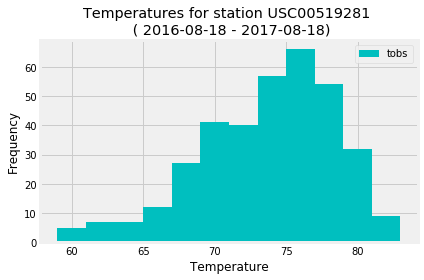

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


#get station with most temperature observations
st_most_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.tobs).desc())\
                        .first()

station_id = st_most_temp_obs[0]


# get latest date
latest_date = session.query(Measurement.date).filter(Measurement.station == station_id)\
                          .order_by(Measurement.date.desc()).first()

#using ravel to extract string from the above query object
latest_date = list(np.ravel(latest_date))[0]

#converting the string returned above to datetime format
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

#calculating the date 1 years ago using timedelta
one_year_ago = (latest_date - dt.timedelta(days=365)).date()

# Temperature Observations for the station for last 12 months
Temp_result = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
                    filter(Measurement.date >= one_year_ago ).\
                    filter(Measurement.station == station_id).all()


# Save the query results as a Pandas DataFrame
station_temp_df = pd.DataFrame(Temp_result)

#plot histogram with bins =12
station_temp_df.plot(kind='hist', bins=12,color = 'c')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperatures for station {station_id} \n ( {one_year_ago} - {latest_date.date() })')
plt.tight_layout()
plt.savefig('Images\Temp_Histogram.png')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
